In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
import numpy as np
from astropy.convolution import convolve
from astropy.coordinates import SkyCoord
from astropy import wcs
from sklearn.cluster import KMeans
from DoG_maps import load_Data

In [2]:
def get_WCS_from_fits(clustername):
    """Takes in a string (clustername) as parameter, finds the associated fits files and returns the world coordinates"""
    hdu_map,img_map,weight_map= load_Data(clustername)
    w=wcs.WCS(hdu_map.header)
    return w

In [3]:
def maskOuterRing(img,radius):
    """Takes in a 2D array and a mask radius as parameters. Sets 2D array values to zero outside a circular region"""
    temp = np.copy(img)
    shape = temp.shape
    dist = np.zeros((shape))
    x_arr = np.arange(shape[0]) - (shape[0]/2)
    y_arr = np.arange(shape[1]) - (shape[1]/2)
    for i in range(len(x_arr)):
        for j in range(len(y_arr)):
            distance=np.sqrt(x_arr[i]**2 + y_arr[j]**2)
            dist[i,j] = distance
    temp[(dist>radius)]=0.0
    return temp

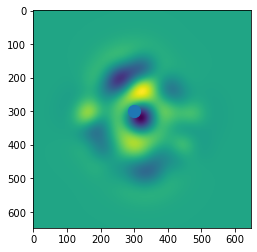

In [10]:
import matplotlib.pyplot as plt

df=np.loadtxt("diff_Gauss_img_map_M0717_theta1_30__theta2_50")
plt.imshow(df)
plt.scatter(300,300,s=150)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
get_filenames(clustername)

In [ ]:
def psrc_finder(dog_map,clustername):
    masked_map = maskByWeight(dog_map,clustername)
    max_mag = np.max(masked_map)
    current_std = np.std(masked_map.flatten())
    current_avg = np.mean(masked_map.flatten())
    rel_mag = max_mag/current_std
    pointsrc_coords_x=[]
    pointsrc_coords_y=[]
    center=np.where(masked_map==np.max(masked_map))
    pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
    pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
    xmin=center[0][0]-10
    xmax=center[0][0]+10
    ymin=center[1][0]-10
    ymax=center[1][0]+10
    masked_map[xmin:xmax,ymin:ymax]=0
    new_avg = np.mean(masked_map.flatten())
    new_std = np.std(masked_map.flatten())
    new_rel_mag = max_mag/new_std
    num_src = 1
    std_arr=[]
    std_arr=np.append(std_arr,new_std)
    source_mag = []
    source_mag = np.append(source_mag,max_mag)
    while num_src<10:
        max_mag = np.max(masked_map)
        current_std = np.std(masked_map.flatten())
        current_avg = np.mean(masked_map.flatten())
        rel_mag = max_mag/current_std
        center = np.where(masked_map==np.max(masked_map))
        pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
        pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
        xmin=center[0][0]-10
        xmax=center[0][0]+10
        ymin=center[1][0]-10
        ymax=center[1][0]+10
        masked_map[xmin:xmax,ymin:ymax]=0
        new_avg = np.mean(masked_map.flatten())
        new_std = np.std(masked_map.flatten())
        new_rel_mag = max_mag/new_std
        num_src+=1
        std_arr = np.append(std_arr,new_std)
        source_mag = np.append(source_mag,max_mag)
    src = np.arange(len(std_arr)-2)
    src = src[np.diff(np.diff(std_arr))>0]
    src = src[0]+2
    return src,pointsrc_coords_x[0:src],pointsrc_coords_y[0:src]


In [4]:
def findPointSources(filtered_img,num_src,mask=True,mask_rad=250):
    """"Takes in 4 parameters, a 2D array, number of sources, mask (Boolean) and radius of mask. Returns the pixel location of the max points in 2D array."""
    temp_data = np.copy(filtered_img)
    pointsrc_coords_x=[]
    pointsrc_coords_y=[]
    if mask == False:
        for i in range(num_src):
            center=np.where(temp_data==np.max(temp_data))
            pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
            pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
            xmin=center[0][0]-10
            xmax=center[0][0]+10
            ymin=center[1][0]-10
            ymax=center[1][0]+10
            temp_data[xmin:xmax,ymin:ymax]=0
    else:
        temp = maskOuterRing(temp_data,mask_rad)
        for i in range(num_src):
            center=np.where(temp==np.max(temp))
            pointsrc_coords_x=np.append(pointsrc_coords_x,center[0][0])
            pointsrc_coords_y=np.append(pointsrc_coords_y,center[1][0])
            xmin=center[0][0]-10
            xmax=center[0][0]+10
            ymin=center[1][0]-10
            ymax=center[1][0]+10
            temp[xmin:xmax,ymin:ymax]=0
    return pointsrc_coords_x,pointsrc_coords_y

In [5]:
def get_filenames(clustername):
    """"Obtains the list of the DoG maps generated with DoG_loop"""
    file_str=clustername+"_files"
    f = open(file_str,"r")
    filename_str_arr = np.genfromtxt(file_str,delimiter=',',dtype=str)
    return filename_str_arr

In [6]:
def Point_Srcs(clustername,dir_str,num_src,mask=True,mask_rad=250):
    """"Takes in a cluster name (string), directory, number of sources (integer), mask (Boolean) and mask radius. Returns a dictionary of point sources of all DoG maps associated with cluster, and a dictionary of all the DoG maps."""
    DoG_diction={}
    filenames_arr=get_filenames(clustername)
    Point_src_diction={}
    for i in filenames_arr:
        full_name_str=dir_str+i
        array_data=np.loadtxt(full_name_str)
        DoG_diction[i]=array_data
        arr_ps_x,arr_ps_y=findPointSources(array_data,num_src,mask,mask_rad)
        Point_src_diction[i]=[arr_ps_x,arr_ps_y]
    return DoG_diction,Point_src_diction

In [9]:
def kMeans_point_sources(clustername,dir_str,num_centers,mask=True,mask_rad=250):
    """"Takes in a dictionary of point sources (keys are names for each DoG map, values are the pixel location of point sources) and returns the kmeans centers (point source location in )"""
    DoG_diction,Point_src_diction = Point_Srcs(clustername,dir_str,num_centers,mask,mask_rad)
    keys=list(Point_src_diction.keys())
    X=[0,0]
    for i in range(len(keys)):
        arr_i=np.array(list(zip(Point_src_diction[keys[i]][0],Point_src_diction[keys[i]][1])))
        X=np.vstack((X,arr_i)) 
    X=X[1:]
    kmeans= KMeans(n_clusters=num_centers,random_state=0).fit(X)
    point_src_centers=kmeans.cluster_centers_
    ##############
    w=get_WCS_from_fits(clustername)
    coords_ra_dec=w.wcs_pix2world(point_src_centers,1)
    return DoG_diction,Point_src_diction,coords_ra_dec,point_src_centers

In [20]:
dirname_str="/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_MOO1506"
DoG_dict_1506,Point_src_dict_1506,coords_1506,psrcs_1506=kMeans_point_sources("MOO1506",dirname_str,6,mask=True,mask_rad=250)
keys_1506=DoG_dict_1506.keys()
keys_1506=list(keys_1506)


IndexError: list index out of range

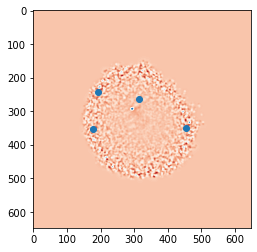

In [23]:
dirname_str="/users/ksarmien/Documents/clusters_substructure/diff_Gauss_img_map_M0717"
DoG_dict_717,Point_src_dict_717,coords_717,psrcs_717=kMeans_point_sources("M0717",dirname_str,4,mask=True,mask_rad=250)
keys_717=DoG_dict_717.keys()
keys_717=list(keys_717)

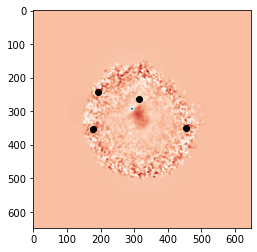

In [26]:
plt.imshow(DoG_dict_717[keys_717[30]],cmap="RdBu")
plt.scatter(psrcs_717[:,1],psrcs_717[:,0],c="k")

In [11]:
keys=DoG_dict.keys()


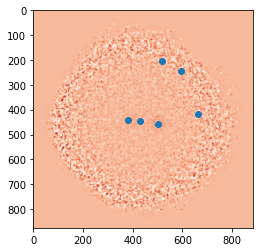

In [22]:
plt.imshow(DoG_dict_1506[keys_1506[10]],cmap="RdBu")
plt.scatter(psrcs_1506[:,1],psrcs_1506[:,0])

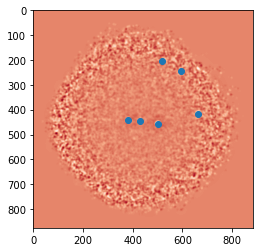

In [19]:
plt.imshow(DoG_dict[list(keys)[20]],cmap="RdBu")
plt.scatter(psrcs[:,1],psrcs[:,0])

In [ ]:
coords,pixels=kMeans_point_sources(Point_src_dict,4)
keys=list(Point_src_dict.keys())
plt.imshow(DoG_dict[keys[80]],cmap="RdBu")
plt.scatter(pixels[:,1],pixels[:,0])

In [ ]:
f = open("DoG.txt","w")
f.write(str(DoG_dict))
f.close()

g = open("PntSrc.txt","w")
g.write(str(Point_src_dict))
g.close()

h = open("DoG_mask.txt","w")
h.write(str(DoG_dict_mask))
h.close()

k = open("PntSrc_mask.txt","w")
k.write(str(Point_src_dict_mask))
k.close()

In [ ]:
len(DoG_dict)

In [ ]:
fig, axs = plt.subplots(14,13)
keys=list(DoG_dict_mask.keys())
count=0
while i<176:
    for i in range(14):
        for j in range(13):
            axs[i,j].imshow(DoG_dict[keys[count]],cmap="RdBu")
            axs[i,j].set_title(keys[count],fontsize=8)
            axs[i,j].scatter(Point_src_dict[keys[count]][1],Point_src_dict[keys[count]][0])
            count+=1

In [ ]:
fig, axs = plt.subplots(9,10,figsize=(15,15))
keys=list(DoG_dict_mask.keys())
count=0
for i in range(9):
    for j in range(10):
        axs[i,j].imshow(DoG_dict_mask[keys[count]],cmap="RdBu")
        axs[i,j].set_title(keys[count],fontsize=8)
        axs[i,j].scatter(Point_src_dict_mask[keys[count]][1],Point_src_dict_mask[keys[count]][0])
        count+=1